In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import os.path
import pickle
from scipy.stats import norm
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
#import pyDOE
from sepia.SepiaModel import SepiaModel
from sepia.SepiaData import SepiaData
import sepia.SepiaPlot as SepiaPlot

In [3]:
load_model = 0
save_model = 0
model_file = 'ball_drop_2_ragged_model'

In [4]:
datadir = "data/data_ball_drop_2/"
# experimental data
with open(datadir+'fieldDat15x6gparam.txt','r') as f:
    field_data = np.loadtxt(f)
with open(datadir+'desNative4x2Rrho.txt','r') as f:
    x = np.loadtxt(f) # x = {R, rho_ball}
x_obs = x

y_obs = [np.array(field_data[0:3,4]),np.array(field_data[3:6,4]),\
         np.array(field_data[6:12,4]),np.array(field_data[12:,4])]
h_obs = [np.array(field_data[0:3,3]),np.array(field_data[3:6,3]),\
         np.array(field_data[6:12,3]),np.array(field_data[12:,3])]# observed heights

# simulated data
with open(datadir+'desNative80x4Cg.txt','r') as f:
    sim_data = np.loadtxt(f)
x_sim = sim_data[:,0:2] # x = {R, rho_ball}
t_sim = sim_data[:,2:4] # t = {C, g}
with open(datadir+'simHeights101x1','r') as f:
    h_sim = np.loadtxt(f)
with open(datadir+'sims101x80Cg.txt','r') as f:
    y_sim = np.loadtxt(f).T

# create sepia data object
data = SepiaData(x_sim = x_sim, t_sim = t_sim, y_ind_sim = h_sim, y_sim = y_sim,\
                 x_obs = x, y_obs = y_obs, y_ind_obs = h_obs)

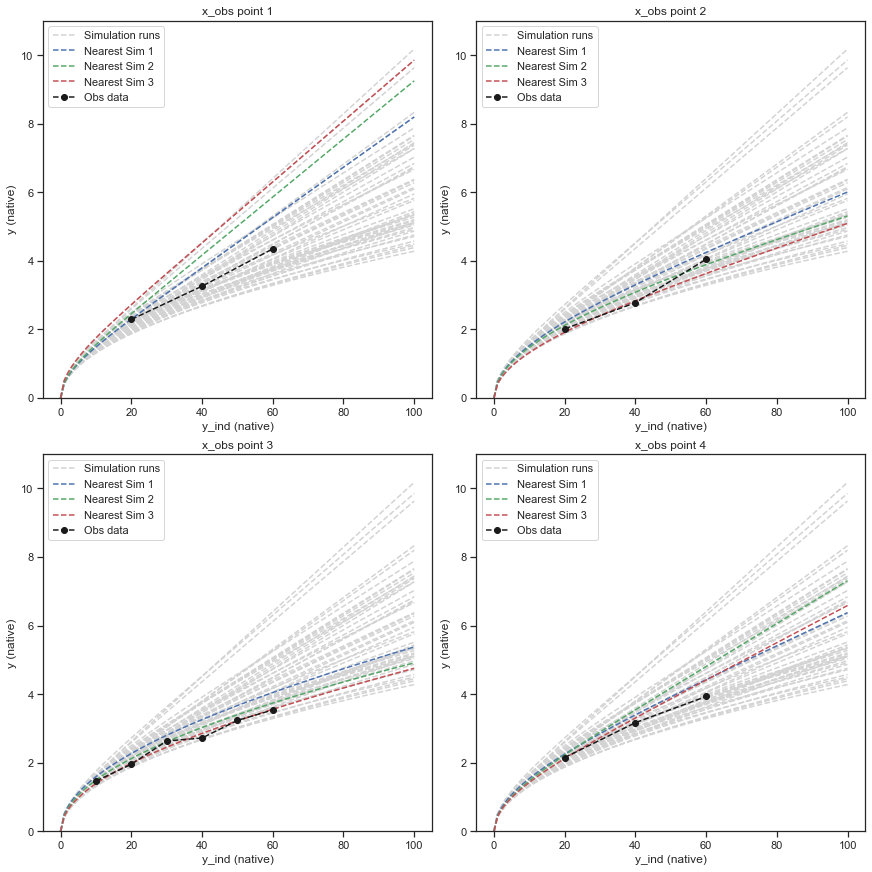

In [5]:
data_figure = SepiaPlot.plot_data(data,x_min = -5, x_max = 105, y_min = 0, y_max = 11)

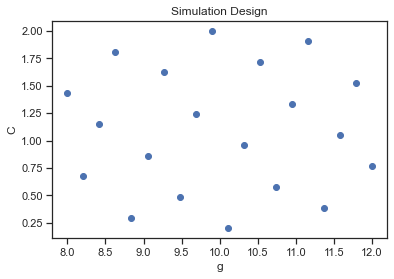

In [6]:
fig,ax = plt.subplots()
ax.scatter(t_sim[0:20,1],t_sim[0:20,0])
ax.set_xlabel("g");ax.set_ylabel("C"),ax.set_title("Simulation Design")
plt.show()

In [7]:
data.transform_xt()
data.standardize_y()

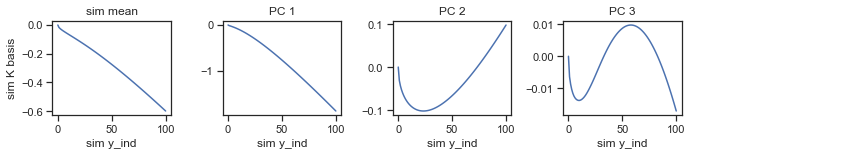

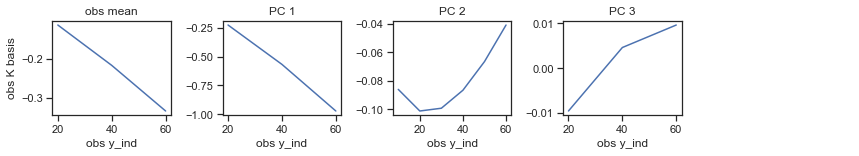

In [8]:
data.create_K_basis(3)
fig_sim, fig_obs = SepiaPlot.plot_K_basis(data)

In [9]:
data.create_D_basis('linear')
print(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 101, obs y dimension ragged
n  =     4 (number of observed data)
m  =    80 (number of simulated data)
p  =     2 (number of inputs)
q  =     2 (number of additional simulation inputs to calibrate)
pu =     3 (transformed response dimension)
pv =     2 (transformed discrepancy dimension)



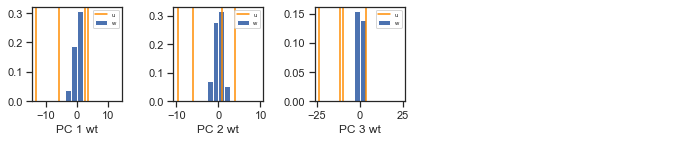

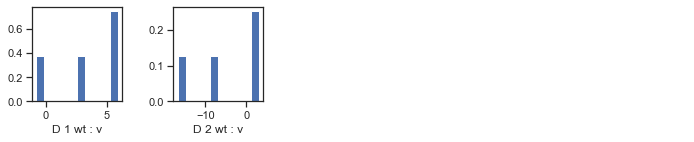

In [10]:
fig_uw, fig_v = SepiaPlot.plot_K_weights(data)

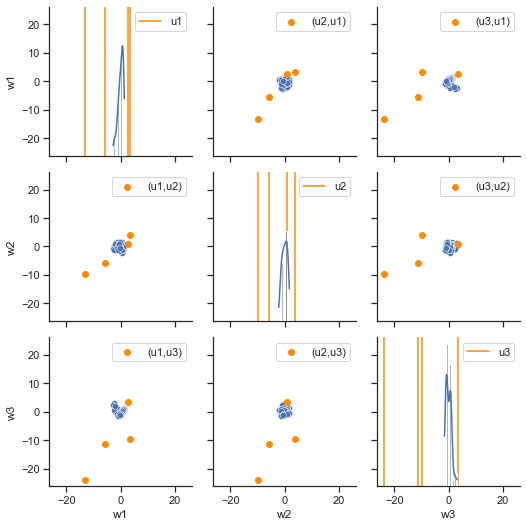

In [11]:
uw_figure = SepiaPlot.plot_u_w_pairs(data)

## MCMC

In [12]:
model = SepiaModel(data)
nsamp = 1000
if os.path.isfile(model_file+'.pkl') and load_model:
    model.restore_model_info(cachefile_name)
else:
    model.tune_step_sizes(50, 20)
    model.do_mcmc(1000)
    if save_model: model.save_model_info(cachefile_name)

lamWOs initialized outside default bounds [60, 1e5]; setting initial value to 1e5 - 1.
Starting tune_step_sizes...
Default step sizes:
theta
[[0.2 0.2]]
betaV
[[0.1]
 [0.1]]
betaU
[[0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]]
lamVz
[[10.]]
lamUz
[[5. 5. 5.]]
lamWs
[[100. 100. 100.]]
lamWOs
[[100.]]
lamOs
[[19.51419672]]


Step size tuning: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


Done with tune_step_size.
Selected step sizes:
theta
[[0.27291914 0.48398283]]
betaV
[[0.06991471]
 [0.57453087]]
betaU
[[0.19461828 0.04816341 0.44374382]
 [0.44791622 0.08174681 0.69345101]
 [0.09791868 0.20690848 0.40681738]
 [0.04430067 0.14932423 0.02589495]]
lamVz
[[6121.92567864]]
lamUz
[[0.31193412 0.31809145 0.46696094]]
lamWs
[[14361.39986128 12459.70806839  6230.85762321]]
lamWOs
[[180.66095431]]
lamOs
[[207.82474438]]


MCMC sampling: 100%|██████████| 1000/1000 [00:17<00:00, 58.72it/s]


In [13]:
samples_dict = model.get_samples()
theta_names = ['C','g']
p_stats = SepiaPlot.param_stats(samples_dict,theta_names=theta_names,q1=.05,q2=.95,digits=4)
print(np.round(p_stats,4))

                      mean         sd  0.05 quantile  0.95 quantile
C                   0.2125     0.0407         0.1459         0.2797
g                   0.5009     0.0747         0.3825         0.6322
betaV_1             0.1116     0.1700         0.0013         0.5113
betaV_2             1.0327     2.2623         0.0026         5.6344
betaU_1             0.2267     0.1234         0.0984         0.4724
betaU_2             0.8948     0.3510         0.4252         1.5964
betaU_3             0.2193     0.0687         0.1370         0.3488
betaU_4             0.0761     0.0259         0.0464         0.1238
betaU_5             0.0504     0.0253         0.0203         0.0999
betaU_6             0.1115     0.0625         0.0427         0.2200
betaU_7             0.8853     0.1875         0.6467         1.1934
betaU_8             0.3332     0.0718         0.2232         0.4511
betaU_9             0.5888     0.3005         0.2515         1.2213
betaU_10            0.8214     0.3945         0.

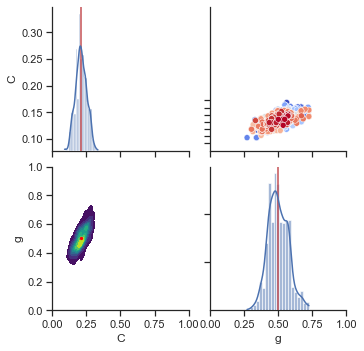

In [14]:
theta_post_fig = SepiaPlot.theta_pairs(samples_dict,theta_names,theta_ref=[[0.2075],[0.5003]])#,save='plots/theta_post.png')

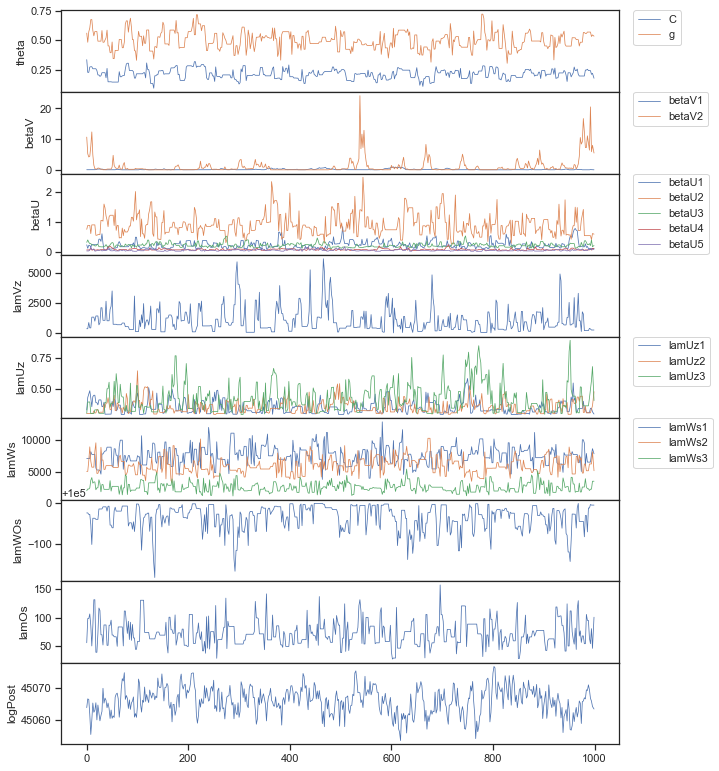

In [15]:
mcmc_trace_fig = SepiaPlot.mcmc_trace(samples_dict,theta_names,start=0,n_to_plot=int(nsamp/2),max_print=5)#,save='plots/mcmc_trace.png')

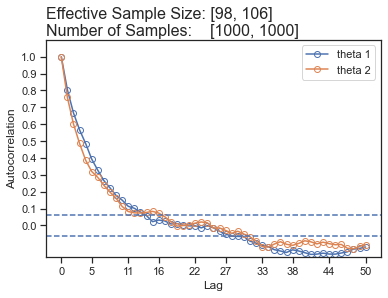

In [16]:
acf = SepiaPlot.plot_acf(model,nlags=50,nburn=0)#,save='plots/acf.png')

In [17]:
from sepia.SepiaPredict import SepiaFullPrediction
pred_samples=model.get_samples(nburn=int(.1*nsamp),effectivesamples=True)
pred=SepiaFullPrediction(x_pred=data.obs_data.x, samples=pred_samples, model=model)

Max effective sample size over thetas: 97
Total samples: 1000


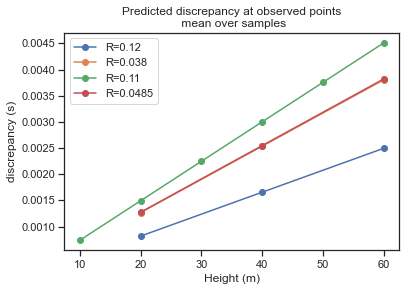

In [18]:
predd=[]
for i in range(4):
    predd.append(pred.get_discrepancy(as_obs=True,obs_ref=i))
fig, ax = plt.subplots()
for i in range(4):
    ax.plot(model.data.obs_data.y_ind[i],np.mean(predd[i],0).T,marker='o',label='R={}'.format(x_obs[i,0]))  
ax.set_xlabel('Height (m)')
ax.set_ylabel('discrepancy (s)')
ax.set_title('Predicted discrepancy at observed points\n mean over samples')
plt.legend()
plt.show()

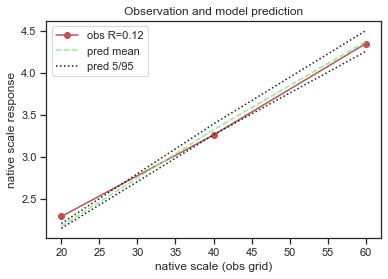

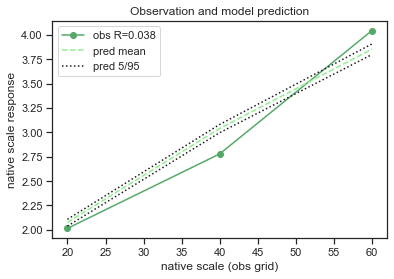

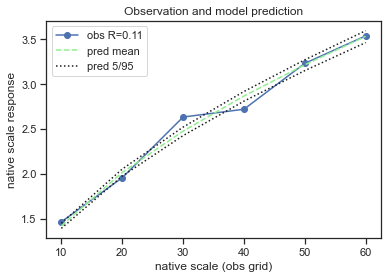

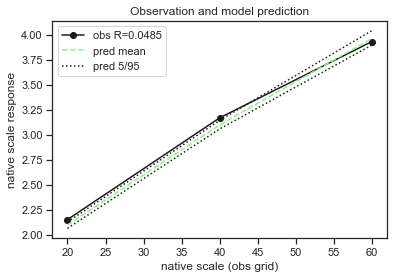

In [19]:
colors = ('r','g','b','k')
for R_idx in range(4):
    plt.figure()
    predyobs=pred.get_yobs(as_obs=True, obs_ref=R_idx)
    plt.plot(model.data.obs_data.y_ind[R_idx],model.data.obs_data.y[R_idx],marker='o',c=colors[R_idx])
    plt.plot(model.data.obs_data.y_ind[R_idx],np.mean(predyobs,0).T,'--',c='lightgreen')
    plt.plot(model.data.obs_data.y_ind[R_idx],np.quantile(predyobs,[0.05, 0.95],axis=0).T,'k:')
    plt.xlabel('native scale (obs grid)')
    plt.ylabel('native scale response')
    plt.title('Observation and model prediction')
    plt.legend(['obs R={}'.format(x_obs[R_idx,0]),'pred mean','pred 5/95'])
    plt.show()